# Notebook for testing NN model for tweet classification
### - Gurpreet

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read the pre-processed csv file from github 

dataset_url = "https://raw.githubusercontent.com/jim1992/capstone-Hinglish-NLP/master/HOT_preprocessed_data.csv"

tweets_df = pd.read_csv(dataset_url)
tweets_df

,old_text,score,text
0,haa,0,ha
1,banti empowered woman feminism gyan pelti din ...,2,banti empowered adult female feminism gyan pel...
2,usko chhod mjse bat baap gya ldki beech madarchod,2,usko chhod mjse words father gya ldki midway m...
3,punjab madarchodon khila nokrian day imran,2,punjab mother fucker khila nokrian day imran
4,chill maar madarchod gand maar lene,2,chill kill motherfucker ass kill lene
...,...,...,...
2998,islamic kashmiri jihaadi suar jisk,1,islamic kashmiri muslim terrorist pig jisk
2999,love jihaadi killed,1,love muslim terrorist killed
3000,madarjaat rand aullad islamic jihaadi,1,mother fucker whore aullad islamic muslim ter...
3001,jihaadi kutte double maut aane,1,muslim terrorist dog double end aane


In [3]:
df = tweets_df[['text','score']]
df

,text,score
0,ha,0
1,banti empowered adult female feminism gyan pel...,2
2,usko chhod mjse words father gya ldki midway m...,2
3,punjab mother fucker khila nokrian day imran,2
4,chill kill motherfucker ass kill lene,2
...,...,...
2998,islamic kashmiri muslim terrorist pig jisk,1
2999,love muslim terrorist killed,1
3000,mother fucker whore aullad islamic muslim ter...,1
3001,muslim terrorist dog double end aane,1


In [4]:
 classCountDf = df.groupby("score",as_index = False)["text"].count()

print("Number of rows per class label:")
print(classCountDf)

Number of rows per class label:
   score  text
0      0   940
1      1   302
2      2  1761


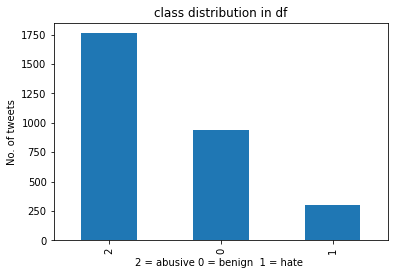

In [5]:
plt.figure()
pd.value_counts(df['score']).plot.bar(title="class distribution in df")
plt.xlabel("2 = abusive 0 = benign  1 = hate ")
plt.ylabel("No. of tweets")
plt.show()

# Reading files from Google Drive
## we will get the embedding files from here

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# authentication of the user for google drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# creating a file with embeddings in the local Instance on which the google colab notebook is running
# the embedding file is in my drive and i have shared it to public and the id is used to access it

downloaded = drive.CreateFile({'id': '1aLBH4FTC_C6eG8Q4W2Jlz1fEPHwWVlrQ'})
file_content = downloaded.GetContentString()

with open('/tmp/glove.twitter.27B.50d.txt','w') as f:
  f.write(file_content)
f.close()


# Importing all the packages required

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_

from nltk.tokenize import RegexpTokenizer


from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score



from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm 
import math

import seaborn as sns
sns.set_context(context="talk")





/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## CNN model

In [0]:
class CNNmodel(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights_matrix, dropout):
        super(CNNmodel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.embedding(x)  #o/p->[batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1) #o/p->[batch size,1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        out = self.linear(out)
        return out

# RNN model


In [0]:
class RNNModel(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, weights_matrix, dropout = 0.5):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        """
    	We permute the input so the size becomes [sequence_length, batch_size] so that we can use the sequence as the time step input for the rnn.
    	"""
        src = src.permute(1,0)
        embedded = self.embedding(src)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out = self.fc(hidden.squeeze())
        return out


#RNN + CNN model

In [0]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, weights_matrix, dropout = 0.5):
        super().__init__()
        """
        We take in the pre-trained embeddings but don't freeze the weights, as the hinglish words might not be in the dictionary. 
        """
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(2*hid_dim, 3)
        self.hid_dim = 2*hid_dim 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        src = src.permute(1,0)
        embedded = self.embedding(src)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return hidden

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights_matrix, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze = False)
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.linear = nn.Linear(len(filter_sizes)*n_filters, output_dim)#
        self.len_layer = len(filter_sizes)*n_filters
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.embedding(x) #o/p->[batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)#o/p->[batch size,1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded.squeeze(3)))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        return out 

class RNN_CNNmodel(nn.Module):
    def __init__(self, cnn, rnn, output_dim, dropout):
        super().__init__()
        self.cnn = cnn
        self.rnn = rnn 
        self.fc1 = nn.Linear(cnn.len_layer + rnn.hid_dim, 100)
        self.maxpool = nn.MaxPool1d(2)
        self.fc2 = nn.Linear(50, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
    	After getting the layer as described above, we pass it through a maxpooling layer and then a linear layer again to get the output. 
    	"""
        out1 = self.cnn(x)
        out2 = self.rnn(x)
        out = torch.cat((out1,out2), dim = 1)
        out = self.fc1(out)
        out = out.unsqueeze(0)
        out = self.maxpool(out)
        out = out.squeeze()
        out = self.fc2(out)
        return out
    

# class Dataset


In [0]:
class dataset(Dataset):
    def __init__(self, df, emb_src ,emb_dim ,vocab = None):
        super(dataset, self).__init__()
        if(vocab == None):
            self.vocab = self.build_vocab(df)
            self.weights_matrix = self.align_pretrained(self.vocab, emb_src, emb_dim)
        else:
            self.vocab = vocab
        data = []
        for i in range(len(df)):
            if(int(df['score'][i]) == 0):
                data.append({'untext' : df['text'][i],'text' : torch.LongTensor(self.preprocess(df['text'][i], self.vocab)),
                             'score' : df['score'][i],  'label' : torch.Tensor([1,0,0])})    
            elif(int(df['score'][i]) == 1):
                data.append({'untext' : df['text'][i],'text' : torch.LongTensor(self.preprocess(df['text'][i], self.vocab)),
                             'score' : df['score'][i],  'label' : torch.Tensor([0,1,0])})
            else:
                data.append({'untext' : df['text'][i],'text' : torch.LongTensor(self.preprocess(df['text'][i], self.vocab)),
                             'score' : df['score'][i],  'label' : torch.Tensor([0,0,1])})    
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def preprocess(self,sentence, vocab):
        sentence = sentence.lower()
        tokenizer = RegexpTokenizer("\w+\'?\w+|\w+")
        tokens = tokenizer.tokenize(sentence)
        word2ids = [vocab['<sos>']]
        word2ids.extend([vocab[word] for word in tokens if word in vocab.keys()])
        word2ids.append(vocab['<eos>'])
        return word2ids
    
    def build_vocab(self,df):
        words = []
        tokenizer = RegexpTokenizer("\w+\'?\w+|\w+")
        for i in range(len(df)):
            sentence = df['text'][i]
            words.extend(tokenizer.tokenize(sentence))
        print(' In build Vocab. building the Vocabulary, words = {}'.format(len(words)))
        words = list(set(words))
        vocab = {}
        vocab['<pad>'] = 0
        vocab['<sos>'] = 1  
        vocab['<eos>'] = 2  
        idx = 3 
        for word in words:
            vocab[word] = idx
            idx += 1 
        return vocab    
    
    def align_pretrained(self, vocab, emb_src, emb_dim):
        glove_file = datapath(emb_src)
        
        tmp_file = get_tmpfile("test_word2vec.txt")

        _ = glove2word2vec(glove_file, tmp_file)

        model = KeyedVectors.load_word2vec_format(tmp_file)
        
        matrix_len = len(vocab) + 1
        weights_matrix = np.zeros((matrix_len, emb_dim))      
        for _,k in enumerate(vocab):
            try:
                weights_matrix[vocab[k]] = model[k]
            except:
                weights_matrix[vocab[k]] = np.random.normal(scale=0.6, size=(emb_dim, ))
        return torch.FloatTensor(weights_matrix)


#Dataloader

In [0]:
def collater(batch):
    sequences = [item['text'] for item in batch]
    untext = [item['untext'] for item in batch]
    score = torch.Tensor([item['score'] for item in batch])
    label = [item['label'] for item in batch]
    label = pad_sequence(label, batch_first= True, padding_value= 0)
    text = pad_sequence(sequences, batch_first=True, padding_value=0)
    new_batch = {'text' : text, 'untext' : untext, 'score' : score, 'label' : label}
    return new_batch

def data_split(df):    
    train, test = train_test_split(df, test_size=0.3)
    test, val = train_test_split(test, test_size = 0.25)
    return train.reset_index(), val.reset_index(), test.reset_index()

#def loader(src,emb_src, emb_dim, batch_size): #add emb_src, emb_dim
def loader(df,emb_src, emb_dim, batch_size):
    """
    Returns Training iterator, Testing iterator, vocab size and weights matrix.  
    """
    #df = pd.read_csv(src, index_col=None, header=0, engine='python' )
    train_df, val_df, test_df = data_split(df)
    train_data = dataset(train_df, emb_src, emb_dim) #add emb_src, emb_dim
    vocab = train_data.vocab
    weights_matrix = train_data.weights_matrix
    val_data = dataset(val_df, emb_src, emb_dim, vocab)
    test_data = dataset(test_df, emb_src, emb_dim, vocab)
    train_data = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, collate_fn= collater ,drop_last=True)
    test_data = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, collate_fn= collater ,drop_last=True)
    val_data = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, collate_fn= collater ,drop_last=True)
    return train_data, val_data, test_data, vocab, weights_matrix

# Trainer

In [0]:
def trainer(model,train_data,val_data,test_data, optimizer, criterion, epochs):
  running_loss = []
  val_loss = []
  running_epochs  = []
  train_accuracy = []
  val_accuracy = []
  best_loss = math.inf
  best_model_state_dict = {k:v for k, v in model.state_dict().items()}
  best_model_state_dict = OrderedDict(best_model_state_dict)
  for epoch in tqdm(range(epochs)):  
    epoch_loss = 0 
    epoch_acc = 0
    epoch_size = 0
    
    model.train()
    
    for batch in tqdm(train_data):
        optimizer.zero_grad()
        src = Variable(batch['text']).cuda()
        out = model(src)
        out = out.squeeze()
        trg = Variable(batch['label']).cuda()
        loss = criterion(out, trg)
        loss.backward()    
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    model.eval()
    
    train_accuracy.append(evaluate(model, train_data))
    running_loss.append(epoch_loss/len(train_data))
    running_epochs.append(epoch+1)
    epoch_loss = 0
    
    with torch.no_grad():
      for batch in tqdm(val_data):
          src = Variable(batch['text']).cuda()
          out = model(src)
          out = out.squeeze()
          trg = Variable(batch['label']).cuda()
          loss = criterion(out, trg)
          epoch_loss += loss.item()

    val_accuracy.append(evaluate(model, val_data))
    val_loss.append(epoch_loss/len(val_data))
    curr_loss = epoch_loss/len(val_data)
    if(curr_loss < best_loss):
      best_loss = curr_loss 
      best_model_state_dict = {k:v for k, v in model.state_dict().items()}
      best_model_state_dict = OrderedDict(best_model_state_dict)
    
  fig= plt.figure(figsize=(5,5,))
  plt.plot(np.array(running_epochs), np.array(running_loss), 'b', label='Training loss')
  plt.plot(np.array(running_epochs), np.array(val_loss), 'g', label = 'validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
  fig= plt.figure(figsize=(5,5))
  plt.plot(np.array(running_epochs), np.array(train_accuracy), 'b', label='Training accuracy')
  plt.plot(np.array(running_epochs), np.array(val_accuracy), 'g', label = 'validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  
  model.load_state_dict(best_model_state_dict)
  print("Accuracy of the Model on Train Data :",evaluate(model, train_data))
  print("Accuracy of the Model on Validation Data :",evaluate(model, val_data))
  print("Accuracy of the Model on Test Data :",evaluate(model, test_data, 1))

# Model Evaluation

In [0]:
def evaluate(model, test_data, test = 0):
  model.eval()
  denom = 0.0
  numer = 0.0
  y_true = [] 
  y_pred = []
  with torch.no_grad():
    for batch in test_data:     
      trg = Variable(batch['label']).cuda()
      src = Variable(batch['text']).cuda()
      out = model(src)
      out = out.squeeze() 
      out = out.data 
      trg = trg.data 
      _,trg1 = torch.max(trg, dim = 1)
      _,out1 = torch.max(out, dim = 1)
      trg1 = trg1.data.cpu().numpy() 
      out1 = out1.data.cpu().numpy() 
      denom += len(trg1)
      for i in range(len(trg1)):
        if(trg1[i] == out1[i]):
          numer += 1
      y_true.extend(trg1.tolist())
      y_pred.extend(out1.tolist())

    
    
    
    if(test):
      precision, recall, fscore, support = score(y_true, y_pred)

      print('precision: {}'.format(precision))
      print('recall: {}'.format(recall))
      print('fscore: {}'.format(fscore))
      print('support: {}'.format(support))

      labels = [0,1,2]
      conf = confusion_matrix(y_true, y_pred, labels = labels)
      df_cm = pd.DataFrame(conf, index = labels, columns = labels)
      plt.figure(figsize = (5,5))
      plt.title('Confusion Matrix')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      sns.heatmap(df_cm.astype(int) , annot=True,cmap="Blues",fmt='g')
      
  return (float(numer)/float(denom))*100

# Run CNN model

 In build Vocab. building the Vocabulary, words = 14022


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


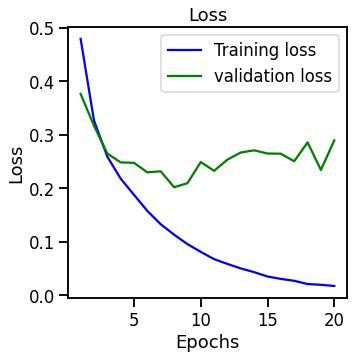

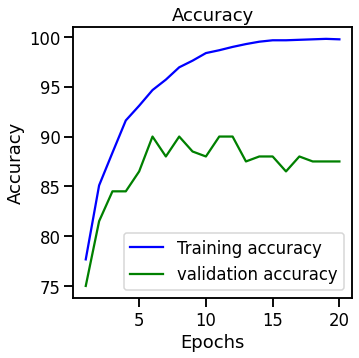

Accuracy of the Model on Train Data : 99.76190476190476
Accuracy of the Model on Validation Data : 86.5
precision: [0.80612245 0.76       0.92079208]
recall: [0.81865285 0.6031746  0.94416244]
fscore: [0.81233933 0.67256637 0.93233083]
support: [193  63 394]
Accuracy of the Model on Test Data : 87.38461538461539


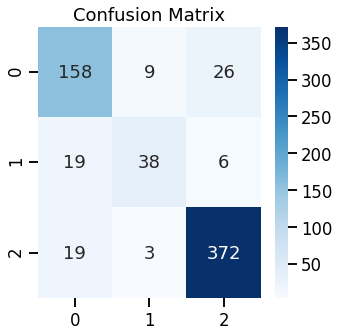

In [24]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


emb_src = "/tmp/glove.twitter.27B.50d.txt"

train_data, val_data, test_data, vocab, weights_matrix = loader(df, emb_src, 50 , 50)



embedding_dim = 50
n_filters = 100
filter_sizes = [3,4,5]
output_dim = 3
dropout = 0.5
num_epoch = 20

model = CNNmodel(embedding_dim, n_filters , filter_sizes, output_dim, weights_matrix ,dropout).cuda()

optimizer = optim.Adam(model.parameters(), lr= 1e-3)
criterion = nn.BCEWithLogitsLoss().cuda()

trainer(model, train_data, val_data,test_data, optimizer, criterion, num_epoch)





#Run the RNN model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


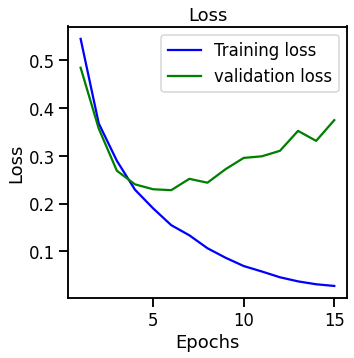

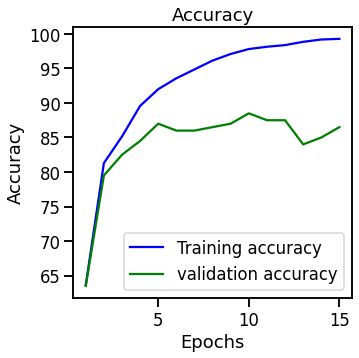

Accuracy of the Model on Train Data : 99.33333333333333
Accuracy of the Model on Validation Data : 85.0
precision: [0.80102041 0.72727273 0.92230576]
recall: [0.80102041 0.63492063 0.94117647]
fscore: [0.80102041 0.6779661  0.93164557]
support: [196  63 391]
Accuracy of the Model on Test Data : 86.92307692307692


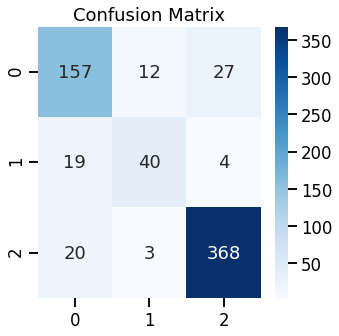

In [25]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# emb_src = "/tmp/glove.twitter.27B.50d.txt"
# train_data, val_data, test_data, vocab, weights_matrix = loader(df, emb_src, 50 , 50)

vocab_size = len(vocab)

output_dim  =  3
emb_dim = 50 
hid_dim = 100 
num_epoch = 15
dropout = 0.5

model = RNNModel(output_dim, emb_dim , hid_dim , weights_matrix,dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
criterion = nn.BCEWithLogitsLoss().cuda()

trainer(model, train_data, val_data,test_data, optimizer, criterion, num_epoch)

#Run RNN + CNN model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


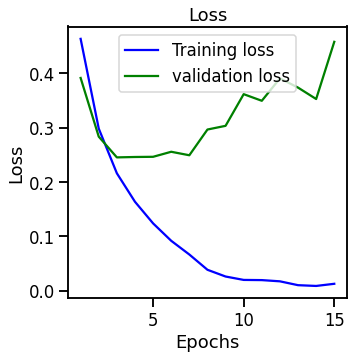

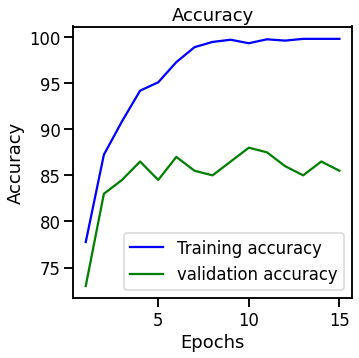

Accuracy of the Model on Train Data : 99.80952380952381
Accuracy of the Model on Validation Data : 87.5
precision: [0.7960199  0.76785714 0.91857506]
recall: [0.81218274 0.69354839 0.92327366]
fscore: [0.8040201  0.72881356 0.92091837]
support: [197  62 391]
Accuracy of the Model on Test Data : 86.76923076923076


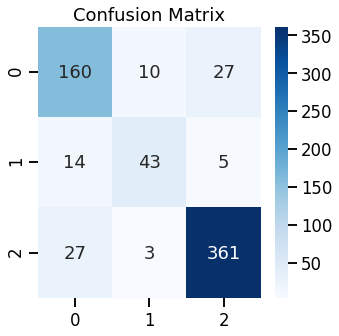

In [26]:
embedding_dim = 50
n_filters = 100
filter_sizes = [3,4,5]
output_dim = 3
dropout = 0.4
num_epoch = 15

# train_data, val_data, test_data, vocab, weights_matrix = loader(df, emb_src, 50 , 50)

cnn = CNN(embedding_dim, n_filters , filter_sizes, output_dim,weights_matrix, dropout).cuda()
rnn = RNN(vocab_size, 50, 100, weights_matrix, dropout = dropout).cuda()

model = RNN_CNNmodel(cnn, rnn, 3, dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
criterion = nn.BCEWithLogitsLoss().cuda()

trainer(model, train_data, val_data,test_data, optimizer, criterion, num_epoch)